*Brian Blaylock*  
*14 September 2018*

# HRRR Lightning and GOES-16 Images

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')

from BB_GOES.get_ABI import get_GOES_truecolor, file_nearest
from BB_GOES.get_GLM import get_GLM_files_for_ABI, accumulate_GLM
from BB_HRRR.HRRR_Pando import get_hrrr_variable
from BB_HRRR.HRRR_RMSD import RMSD
from BB_maps.my_basemap import draw_HRRR_map
from BB_cmap.NWS_standard_cmap import cm_wind, cm_temp, cm_dpt
from BB_cmap.reflectivity_cmap import reflect_ncdc

In [4]:
m = draw_HRRR_map()

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15,15]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [6]:
DATE = datetime(2018, 8, 12, 21)

### Get ABI

In [7]:
FILE = file_nearest(DATE)
ABI = get_GOES_truecolor(FILE, verbose=False)

### Get GLM

In [8]:
GLM_files = get_GLM_files_for_ABI(FILE)

In [9]:
GLM = accumulate_GLM(GLM_files)

### HRRR RMSD

In [10]:
variable = 'UVGRD:10 m'
rmsd = RMSD(DATE, variable)

if variable in ['LTNG:entire']:
    fxx = 1
    cmap = {'cmap':'plasma'}
elif variable in ['REFC:entire']:
    fxx = 0
    cmap = reflect_ncdc()
elif variable in ['TMP:2 m']:
    fxx = 0
    cmap = cm_temp()
elif variable in ['UVGRD:10 m']:
    fxx = 0
    cmap = cm_wind()  


(19, 1059, 1799)


/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
H = get_hrrr_variable(DATE, variable, fxx=fxx)
if variable.split(':')[0] == 'UVGRD':
    masked = H['SPEED']
else:
    masked = H['value']
masked = np.ma.array(masked)
masked[masked <= 0.02] = np.ma.masked


 >> Dowloading tempfile: ./temp_hrrr_2018081221_f00_UVG.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180812/hrrr.t21z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180812/hrrr.t21z.wrfsfcf00.grib2.idx
 >> Matched a variable:  71:41686460:d=2018081221:UGRD:10 m above ground:anl:
 >> Byte Range: 41686460 43841792
 >> Converting winds to earth-relative


### Plot Image

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


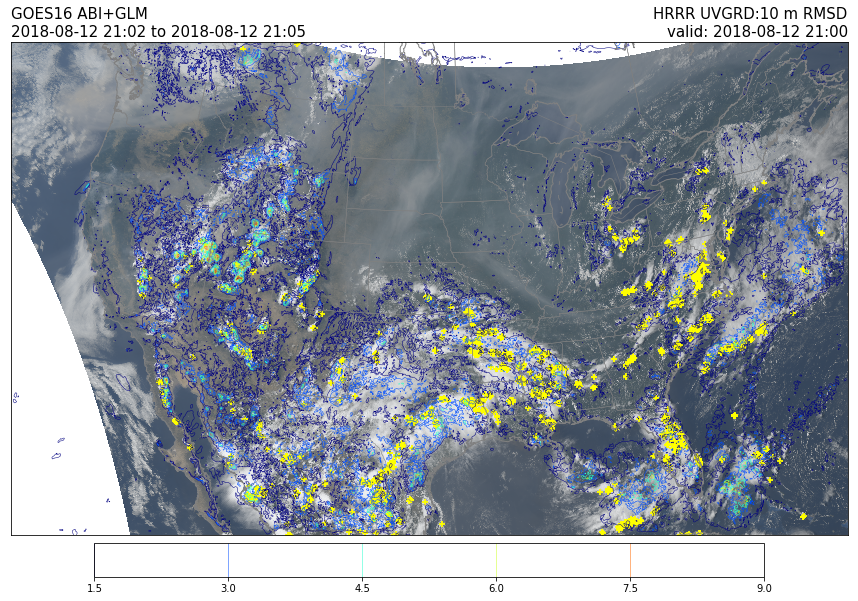

In [12]:
# Plot ABI
newmap = m.pcolormesh(ABI['lon'], ABI['lat'], ABI['TrueColor'][:,:,0], color=ABI['rgb_tuple'], linewidth=0, latlon=True)
newmap.set_array(None)

# Plot HRRR RMSD
m.contour(rmsd['lon'], rmsd['lat'], rmsd['RMSD'], linewidths=.5, latlon=True, cmap='jet')
plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)

# Plot GLM
m.scatter(GLM['longitude'], GLM['latitude'], c='yellow', marker='+', latlon=True)

m.drawcoastlines(color='grey')
m.drawcountries(color='grey')
m.drawstates(color='grey')

plt.title('GOES16 ABI+GLM\n%s to %s' % (ABI['sDATE'].strftime('%Y-%m-%d %H:%M'), ABI['eDATE'].strftime('%Y-%m-%d %H:%M')), loc='left')
plt.title('HRRR %s RMSD\nvalid: %s' % (variable,H['valid'].strftime('%Y-%m-%d %H:%M')), loc='right')

plt.savefig('figs/Lightning_GOES_HRRR-%s_%s' % (variable.replace(':', '-').replace(' ', '-'), DATE.strftime('%Y%m%d-%H%M')))

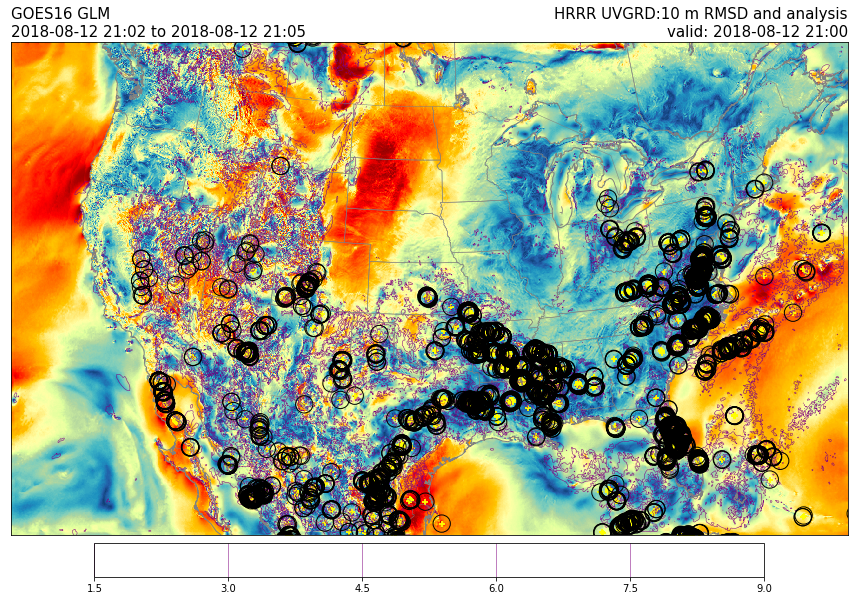

In [11]:
# Plot HRRR value
m.pcolormesh(H['lon'], H['lat'], masked, latlon=True, cmap=cmap['cmap'])

# Plot HRRR RMSD
m.contour(rmsd['lon'], rmsd['lat'], rmsd['RMSD'], linewidths=.5, colors='purple', latlon=True)
plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)

# Plot GLM
m.scatter(GLM['longitude'], GLM['latitude'], c='yellow', marker='+', latlon=True)
m.scatter(GLM['longitude'], GLM['latitude'], edgecolors='k', s=300, marker='o', facecolors='none', latlon=True, zorder=100)

m.drawcoastlines(color='grey')
m.drawcountries(color='grey')
m.drawstates(color='grey')

plt.title('GOES16 GLM\n%s to %s' % (ABI['sDATE'].strftime('%Y-%m-%d %H:%M'), ABI['eDATE'].strftime('%Y-%m-%d %H:%M')), loc='left')
plt.title('HRRR %s RMSD and analysis\nvalid: %s' % (variable,H['valid'].strftime('%Y-%m-%d %H:%M')), loc='right')

plt.savefig('figs/Lightning_GLM_HRRR-%s_%s' % (variable.replace(':', '-').replace(' ', '-'), DATE.strftime('%Y%m%d-%H%M')))

In [12]:
rmsd1 = RMSD(DATE, 'TMP:2 m')
rmsd2 = RMSD(DATE, 'UVGRD:10 m')

(19, 1059, 1799)
(19, 1059, 1799)


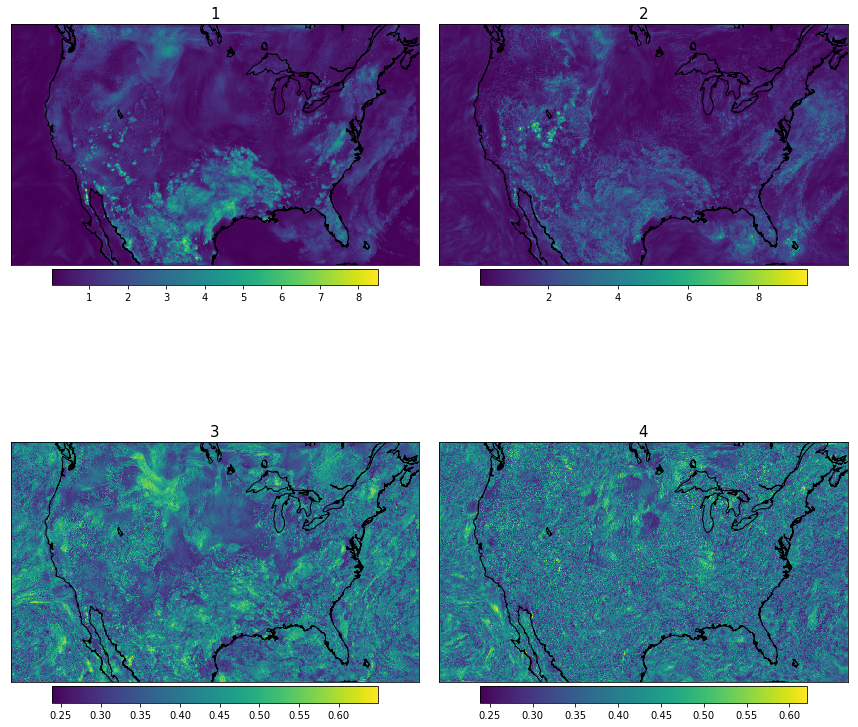

In [17]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)

plt.sca(ax1)
plt.title('1')
m.pcolormesh(H['lon'], H['lat'], rmsd1['RMSD'], latlon=True)
m.drawcoastlines()
plt.colorbar(orientation='horizontal', shrink=.8, pad=.01)

plt.sca(ax2)
plt.title('2')
m.pcolormesh(H['lon'], H['lat'], rmsd2['RMSD'], latlon=True)
m.drawcoastlines()
plt.colorbar(orientation='horizontal', shrink=.8, pad=.01)

plt.sca(ax3)
plt.title('3')
m.pcolormesh(H['lon'], H['lat'], rmsd1['normalized RMSD by range'], latlon=True)
m.drawcoastlines()
plt.colorbar(orientation='horizontal', shrink=.8, pad=.01)

plt.sca(ax4)
plt.title('4')
m.pcolormesh(H['lon'], H['lat'], rmsd2['normalized RMSD by range'], latlon=True)
m.drawcoastlines()
plt.colorbar(orientation='horizontal', shrink=.8, pad=.01)

In [ ]:
DATE